In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram

In [3]:

def read_dataset(name='data/factor_capacidad_conjunto.csv',data='solar'):
    df = pd.read_csv(name,index_col=0,parse_dates=True)
    df = df.rename(columns={
        data: 'y'
    })
    df['ds'] = df.index
    df.loc[:,'unique_id'] = 0
    return df[['y', 'ds', 'unique_id']]

data_solar = read_dataset(data='solar')
data_eolic = read_dataset(data='eolica')
data_eolic.head()

,y,ds,unique_id
index,,,
2014-11-01 00:00:00+00:00,0.150255,2014-11-01 00:00:00+00:00,0
2014-11-01 01:00:00+00:00,0.138126,2014-11-01 01:00:00+00:00,0
2014-11-01 02:00:00+00:00,0.116548,2014-11-01 02:00:00+00:00,0
2014-11-01 03:00:00+00:00,0.100003,2014-11-01 03:00:00+00:00,0
2014-11-01 04:00:00+00:00,0.085874,2014-11-01 04:00:00+00:00,0


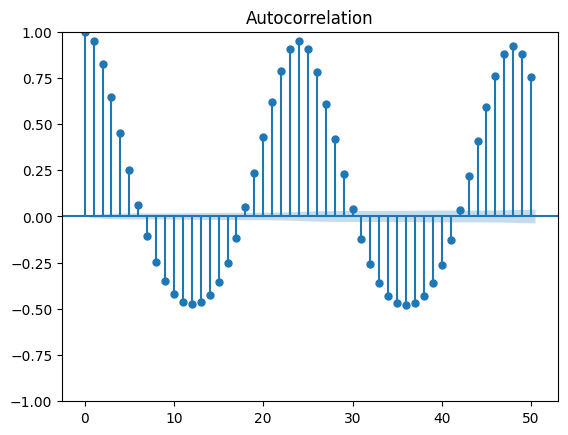

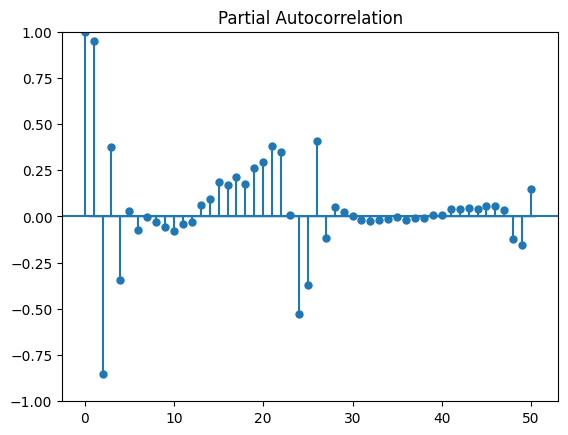

In [5]:
plot_acf(data_solar['y'])
plt.show()
plot_pacf(data_solar['y'])
plt.show()

Seasonality at lags 12, 24, 24*30
M = 4
AR = 2

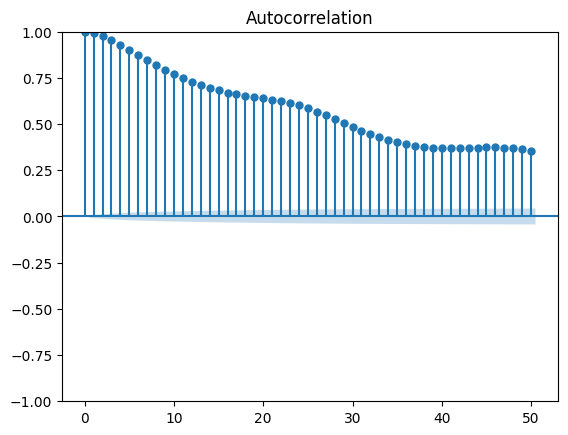

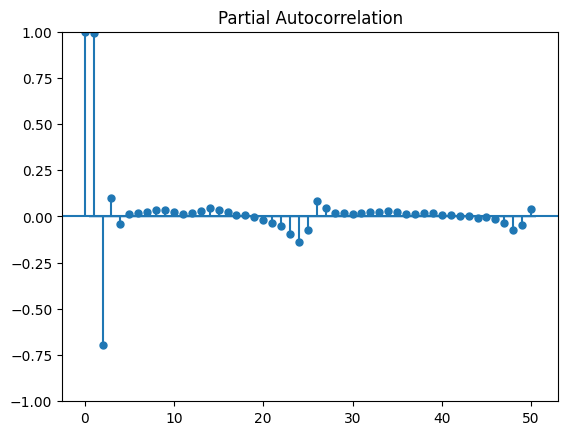

In [6]:
plot_acf(data_eolic['y'])
plt.show()
plot_pacf(data_eolic['y'])
plt.show()

## Modelo ARIMA

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox

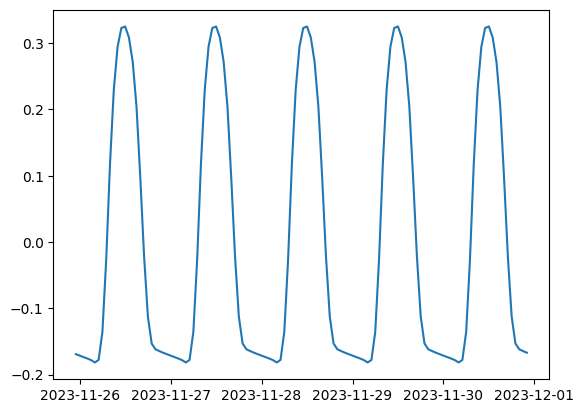

In [11]:
res = seasonal_decompose(data_solar['y'])
plt.plot(res.seasonal.iloc[-24*5:])

In [44]:
def create_fourier(df, freqs=[24,24*365]):
    T = len(df)
    t = np.arange(0,T)
    result_df = df.copy()
    for f in freqs:
        res = np.sin(2*np.pi*t/f)
        result_df[f'sen_{f}'] = res
        cos = np.sin(2*np.pi*t/f)
        result_df[f'cos_{f}'] = res
    return result_df

def create_arima_df(df, lags=[24, 24*365], freqs=[24, 24*365]):
    df = create_fourier(df[['y']], freqs=freqs)
    for l in lags:
        df[f'lag_{l}'] = df['y'].shift(l)
    return df.dropna()
df['y'] = np.clip(df['y'], 0.0001, np.inf)
df['y'], lambda_boxcox = boxcox(df['y'])
df = create_arima_df(data_solar[['y']])
y = df['y']
X = df[df.columns.difference(['y'])]
y_train = y[:-24*20]
y_test = y[-24*20:]
X_train = X[:-24*20]
X_test = X[-24*20:]
model = ARIMA(y_train, exog=X_train, order=(5,1,5))
results = model.fit()
results.summary()

/home/fcelaya/tfm/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/fcelaya/tfm/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/fcelaya/tfm/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/fcelaya/tfm/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/fcelaya/tfm/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                70367
Model:                 ARIMA(5, 1, 5)   Log Likelihood              189090.163
Date:                Wed, 06 Mar 2024   AIC                        -378146.326
Time:                        02:52:28   BIC                        -377990.581
Sample:                    11-01-2015   HQIC                       -378098.302
                         - 11-10-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cos_24     -7.145e-05      0.000     -0.167      0.868      -0.001       0.001
cos_8760      -0.0005      0.023     -0.023      0.982      -0.045       0.044
lag_24         0.7132      0.002    432.356      0.000       0.710       0.716
lag_8760       0.2342      0.002    147.669      0.000       0.231       0.237
sen_24     -7.145e-05      0.000     -0.167      0.868      -0.001       0.001
sen_8760      -0.0005      0.023     -0.023      0.982      -0.045       0.044
ar.L1          1.0732      0.042     25.611      0.000       0.991       1.155
ar.L2         -0.2906      0.048     -6.107      0.000      -0.384      -0.197
ar.L3         -0.6981      0.043    -16.065      0.000      -0.783      -0.613
ar.L4          0.9953      0.045     21.986      0.000       0.907       1.084
ar.L5         -0.3564      0.016    -22.537      0.000      -0.387      -0.325
ma.L1         -0.3547      0.042     -8.405      0.000      -0.437      -0.272
ma.L2         -0.3476      0.038     -9.225      0.000      -0.421      -0.274
ma.L3          0.6287      0.048     13.094      0.000       0.535       0.723
ma.L4         -0.5398      0.033    -16.322      0.000      -0.605      -0.475
ma.L5         -0.2786      0.018    -15.813      0.000      -0.313      -0.244
sigma2         0.0003   7.26e-07    371.560      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):            162150.62
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.53e+18. Standard errors may be unstable.
"""

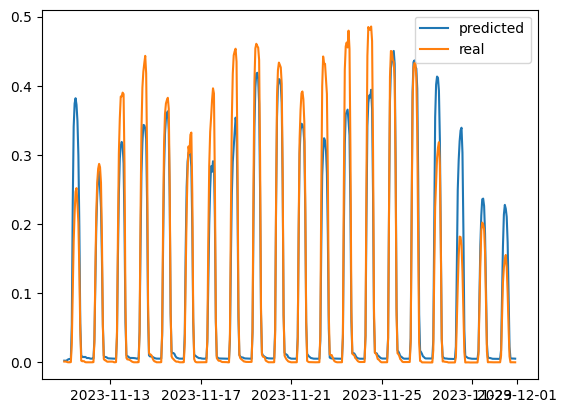

In [45]:
forecast = results.get_forecast(steps=24*20, exog=X_test)
forecast = forecast.predicted_mean
forecast_adj = inv_boxcox(forecast, lambda_boxcox)
y_test_adj = inv_boxcox(y_test, lambda_boxcox)
plt.plot(forecast)
plt.plot(y_test)
plt.legend(['predicted', 'real'])